# **Introduction**

## **Pneumothorax**

A **pneumothorax** occurs when air leaks into the space between your lung and chest wall. This air pushes on the outside of your lung and makes it collapse. **Pneumothorax** can be a complete lung collapse or a collapse of only a portion of the lung.


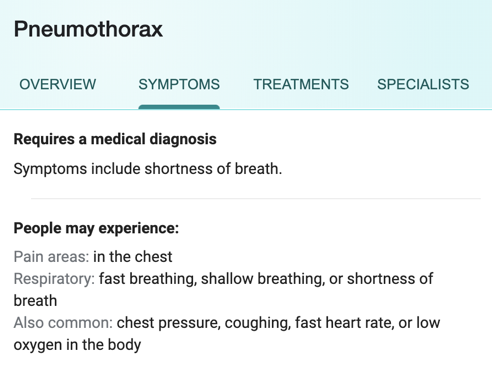

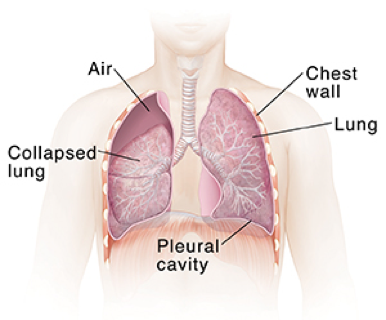

## **Dataset**

* DICOM: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation

* PNG: https://www.kaggle.com/abhishek/siim-png-images

* Dimensions: 1024 x 1024

* 12954 images (Train: 11582, Test: 1372)

* Applied K-fold, total number of folds = 5 -> Train / Validation: 80%/20%

* Reference to a kernel in kaggle: https://www.kaggle.com/rishabhiitbhu/unet-with-resnet34-encoder-pytorch/data

# **Preparation**

In [0]:
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor
warnings.filterwarnings("ignore")

In [0]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 

In [0]:
import segmentation_models_pytorch as smp

In [0]:
from google.colab import files
src = list(files.upload().values())[0]
open('/content/mask_functions.py','wb').write(src)

from mask_functions import rle2mask, mask2rle

In [0]:
!pip install pydicom

     |████████████████████████████████| 35.3MB 92kB/s 


In [0]:
import pydicom
from glob import glob
from matplotlib import patches as patches

from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import subplots
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis

# **Exploration Data Analysis**

## **Convert DICOM to dataframe**

In [0]:
rles_df = pd.read_csv('/content/all-rle.csv')
rles_df.columns = ['ImageId', 'EncodedPixels']

In [0]:
def dicom_to_dict(dicom_data, file_path, rles_df, encoded_pixels=True):
    """
    Parse DICOM dataset and returns a dictonary with relevant fields.

    Args:
        dicom_data (dicom): chest x-ray data in dicom format.
        file_path (str): file path of the dicom data.
        rles_df (pandas.core.frame.DataFrame): Pandas dataframe of the RLE.
        encoded_pixels (bool): if True we will search for annotation.

    Returns:
        dict: contains metadata of relevant fields.
    """

    data = {}

    data['patient_name'] = dicom_data.PatientName
    data['patient_id'] = dicom_data.PatientID
    data['patient_age'] = int(dicom_data.PatientAge)
    data['patient_sex'] = dicom_data.PatientSex
    data['pixel_spacing'] = dicom_data.PixelSpacing
    data['file_path'] = file_path
    data['id'] = dicom_data.SOPInstanceUID

    if encoded_pixels:
        encoded_pixels_list = rles_df[rles_df['ImageId'] == dicom_data.SOPInstanceUID]['EncodedPixels'].values

        pneumothorax = False
        for encoded_pixels in encoded_pixels_list:
            if encoded_pixels != '-1':
                pneumothorax = True

        data['encoded_pixels_list'] = encoded_pixels_list
        data['has_pneumothorax'] = pneumothorax
        data['encoded_pixels_count'] = len(encoded_pixels_list)

    return data


In [0]:
!unzip "/content/dicom-images-all.zip"

## **Parse DICOM dataset**

In [0]:
data_fns = sorted(glob('/content/dicom-images-all/*/*/*.dcm'))
data_df = pd.DataFrame()
data_list = []
for file_path in tqdm(data_fns):
    dicom_data = pydicom.dcmread(file_path)
    data_metadata = dicom_to_dict(dicom_data, file_path, rles_df)
    data_list.append(data_metadata)
data_df = pd.DataFrame(data_list)

## **Original X-ray visualization**

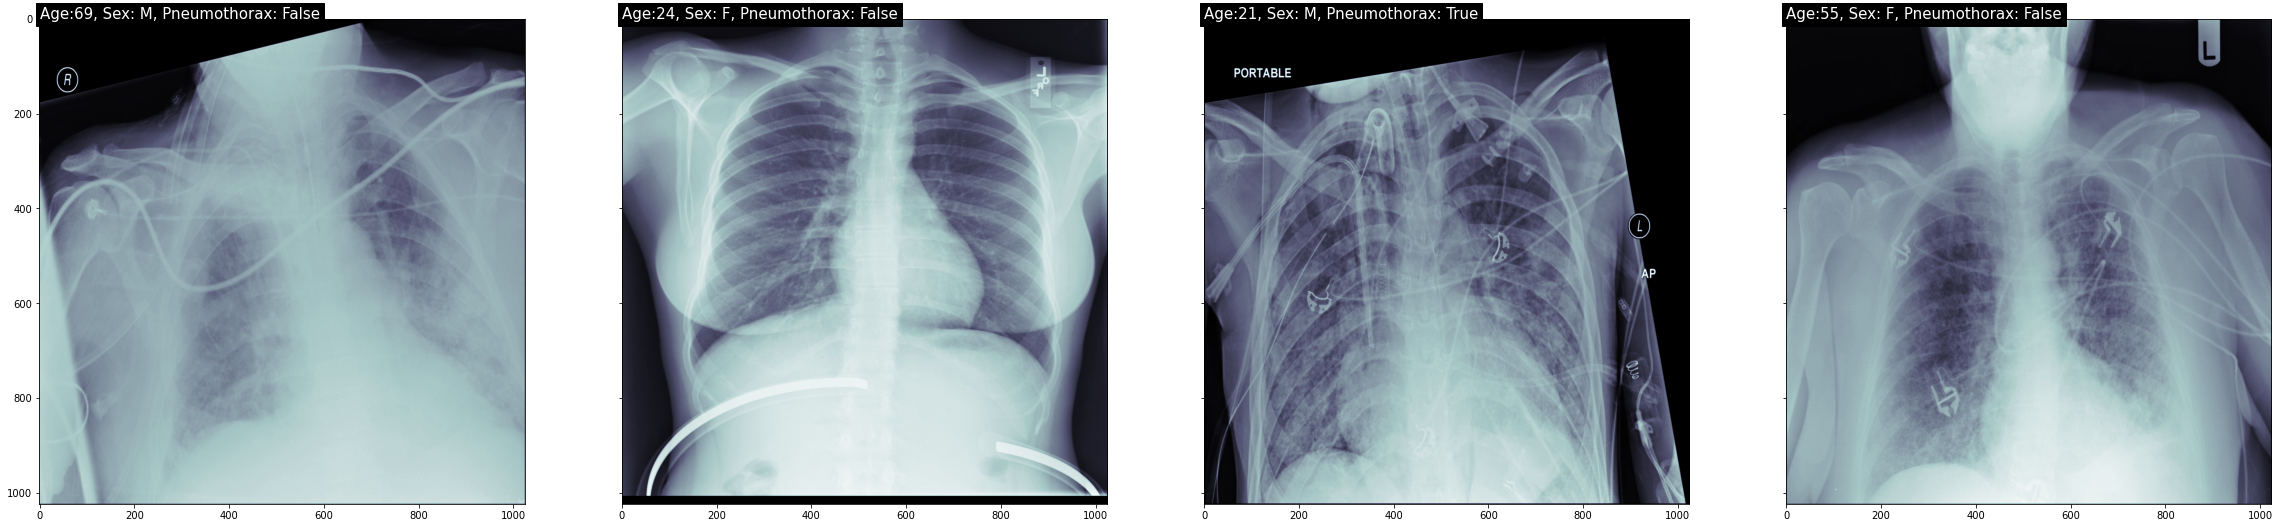

In [0]:
num_img = 4
subplot_count = 0
fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
for index, row in data_df.sample(n=num_img).iterrows():
    dataset = pydicom.dcmread(row['file_path'])
    ax[subplot_count].imshow(dataset.pixel_array, cmap=plt.cm.bone)
    # label the x-ray with information about the patient
    ax[subplot_count].text(0,0,'Age:{}, Sex: {}, Pneumothorax: {}'.format(row['patient_age'],row['patient_sex'],row['has_pneumothorax']),
                           size=15,color='white', backgroundcolor='black')
    subplot_count += 1
#plt.show()

## **Mask visualization**



In [0]:
def bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax


def plot_with_mask_and_bbox(file_path, mask_encoded_list, figsize=(20, 10)):

    """
    Plot Chest Xray image with mask (annotation or label) and without mask.

    Args:
        file_path (str): file path of the dicom data.
        mask_encoded (numpy.ndarray): Pandas dataframe of the RLE.

    Returns:
        plots the image with and without mask.
    """

    pixel_array = pydicom.dcmread(file_path).pixel_array

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
    clahe_pixel_array = clahe.apply(pixel_array)

    # use the mask function to decode RLE
    mask_decoded_list = [rle2mask(mask_encoded, 1024, 1024).T for mask_encoded in mask_encoded_list]

    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(20, 10))

    ax[0].imshow(pixel_array, cmap=plt.cm.bone)
    # print the bounding box
    for mask_decoded in mask_decoded_list:
        # print out the annotated area
        ax[0].imshow(mask_decoded, alpha=0.3, cmap="Reds")
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin, rmin), cmax - cmin, rmax - rmin, linewidth=1, edgecolor='r', facecolor='none')
        ax[0].add_patch(bbox)
    ax[0].set_title('With Mask')

    # plot image with CLAHE processing with just bounding box and no mask
    ax[1].imshow(clahe_pixel_array, cmap=plt.cm.bone)
    for mask_decoded in mask_decoded_list:
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin, rmin), cmax - cmin, rmax - rmin, linewidth=1, edgecolor='r', facecolor='none')
        ax[1].add_patch(bbox)
    ax[1].set_title('Without Mask - CLAHE')

    # plot plain xray with just bounding box and no mask
    ax[2].imshow(pixel_array, cmap=plt.cm.bone)
    for mask_decoded in mask_decoded_list:
        rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
        bbox = patches.Rectangle((cmin, rmin), cmax - cmin, rmax - rmin, linewidth=1, edgecolor='r', facecolor='none')
        ax[2].add_patch(bbox)
    ax[2].set_title('Without Mask')
    plt.show()


In [0]:
# take 5 random samples of X-ray
data_sample = data_df[data_df['has_pneumothorax']==1].sample(n=5)
# plot X-ray with and without mask
for index, row in data_sample.iterrows():
    file_path = row['file_path']
    mask_encoded_list = row['encoded_pixels_list']
    print('image id: ' + row['id'])
    plot_with_mask_and_bbox(file_path, mask_encoded_list)

## **CLAHE**

* **Adaptive histogram equalization (AHE)** is a computer image processing technique used to **improve contrast in images**. It differs from ordinary **histogram equalization** in the respect that the adaptive method computes several histograms, each corresponding to a distinct section of the image, and uses them to **redistribute the lightness values of the image**. It is therefore suitable for improving the local contrast and enhancing the definitions of edges in each region of an image.
* However, AHE tends to **overamplify noise** in relatively homogeneous regions of an image. A variant of adaptive histogram equalization called **contrast limited adaptive histogram equalization (CLAHE)** prevents this by limiting the amplification.




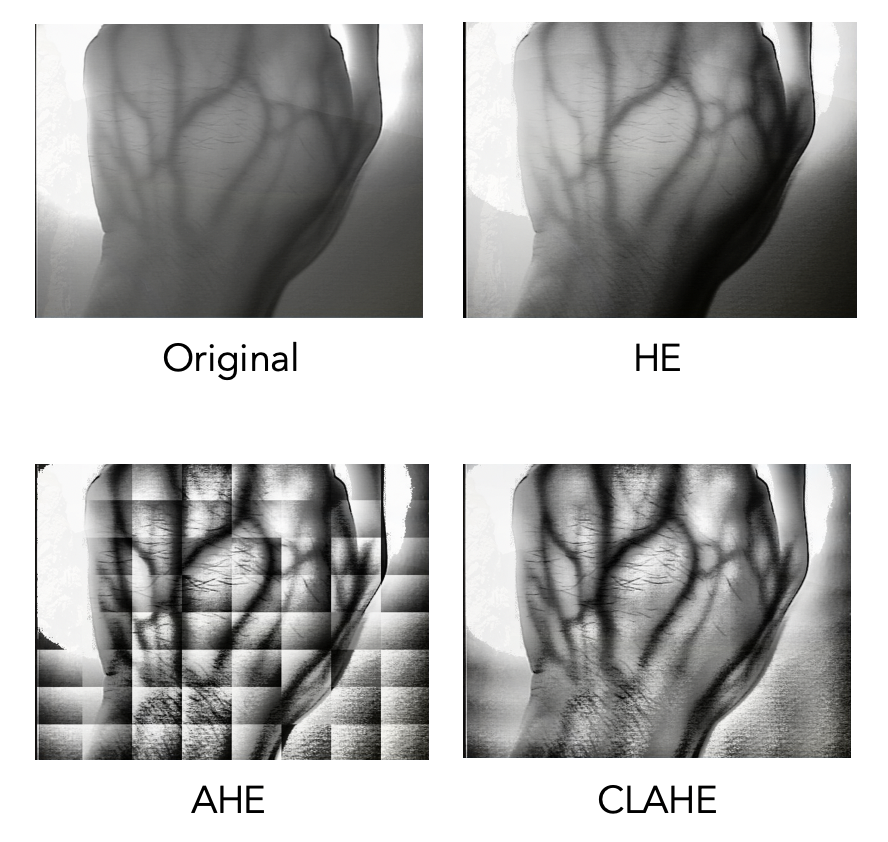

## **Mask / Label exploration**

Print missing labels

In [0]:
missing_vals = data_df[data_df['encoded_pixels_count']==0]['encoded_pixels_count'].count()
print("Number of X-rays with missing labels: {}".format(missing_vals))

Number of x-rays with missing labels: 42


Plot instances features

In [0]:
yes_count = data_df['has_pneumothorax'].sum()
no_count = len(data_df) - yes_count
x = ['No Pneumothorax','Pneumothorax']
y = [no_count, yes_count]
trace0 = Bar(x=x, y=y, name = 'No Pneumothorax vs Pneumothorax')
yes_encoded_pixels_count = data_df[data_df['has_pneumothorax']==1]['encoded_pixels_count'].values
trace1 = Histogram(x=yes_encoded_pixels_count, name='# of Pneumothorax Instances')
fig = subplots.make_subplots(rows=1, cols=2)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=400, width=900, title='Pneumothorax Instances')
fig.show()

* Patients with pneumothorax belong to the minority
* There are 42 X-rays with missing labels
* For most of the X-rays, there is only one mask that is labeled
* But there are still a considerable amount of images with more than one area labeled


## **Age, Gender, and Pneumothorax exploration**

In [0]:
pneumo_pat_age = data_df[data_df['has_pneumothorax']==1]['patient_age'].values
no_pneumo_pat_age = data_df[data_df['has_pneumothorax']==0]['patient_age'].values

pneumothorax = Histogram(x=pneumo_pat_age, name='has pneumothorax')
no_pneumothorax = Histogram(x=no_pneumo_pat_age, name='no pneumothorax')
fig = subplots.make_subplots(rows=1, cols=2)
fig.append_trace(pneumothorax, 1, 1)
fig.append_trace(no_pneumothorax, 1, 2)
fig['layout'].update(height=400, width=900, title='Patient Age Histogram')
fig.show()

Remove outliers and boxplot

In [0]:
trace1 = Box(x=pneumo_pat_age, name='has pneumothorax')
trace2 = Box(x=no_pneumo_pat_age[no_pneumo_pat_age <= 120], name='no pneumothorax')
data = [trace1, trace2]
fig = Figure(data=data)
fig['layout'].update(height=400, width=900, title='Patient Age Boxplot')
fig.show()

* There are two anomalies for the age value in the dataset
* The trend and distribution of age are basically the same for patients with or without pneumothorax


## **Male & Female analysis**

In [0]:
male_df = data_df[data_df['patient_sex']=='M']
female_df = data_df[data_df['patient_sex']=='F']

male_no_count = len(male_df[male_df['has_pneumothorax']==0])
female_no_count = len(female_df[female_df['has_pneumothorax']==0])
male_yes_count = len(male_df[male_df['has_pneumothorax']==1])
female_yes_count = len(female_df[female_df['has_pneumothorax']==1])

no = Bar(x=['male', 'female'], y=[male_no_count, female_no_count], name='no pneumothorax')
yes = Bar(x=['male', 'female'], y=[male_yes_count, female_yes_count], name='has pneumothorax')
data = [no, yes]
layout = Layout(barmode='stack', height=400, width=600)
fig = Figure(data=data, layout=layout)
fig.show()

* According to the given dataset, we can see that there are more instances of male X-rays, but we can see by the proportion that male and female are equally likely to have Pneumothorax


## **Affected area analysis**

In [0]:
def get_affected_area(encoded_pixels_list, pixel_spacing):
    # take the encoded mask, decode, and get the sum of nonzero elements
    pixel_sum = 0

    for encoded_mask in encoded_pixels_list:
        mask_decoded = rle2mask(encoded_mask, 1024, 1024).T
        pixel_sum += np.count_nonzero(mask_decoded)

    area_per_pixel = pixel_spacing[0] * pixel_spacing[1]

    return pixel_sum * area_per_pixel

# create a subset of dataframe for pneumothorax patients
pneumothorax_df = data_df[data_df['has_pneumothorax']==1].copy()
# get sum of non-zero elements in mask
pneumothorax_df['pneumothorax_area'] = pneumothorax_df.apply(lambda row: get_affected_area(row['encoded_pixels_list'], row['pixel_spacing']),axis=1)



Create age categories

In [0]:
def age_categories(age):
    # take age as input and return age category
    if age <= 14:
        return 'Child'
    if age >=15 and age <= 24:
        return 'Youth'
    if age >=25 and age <=64:
        return 'Adult'
    if age >= 65:
        return 'Senior'

pneumothorax_df['age_category'] = pneumothorax_df['patient_age'].apply(age_categories)

# loop over the different age categories and M and F genders to create a subplot
data = []
fig = subplots.make_subplots(rows=2, cols=2, subplot_titles=('Child', 'Youth', 'Adult', 'Senior'))
subplot_positions = [(1, 1), (1, 2), (2, 1), (2, 2)]

# loop over each age category
for i, cat in enumerate(['Child', 'Youth', 'Adult', 'Senior']):
    # and gender
    for gender in ['M', 'F']:
        # get affected area for given age group and gender
        values = pneumothorax_df[(pneumothorax_df['patient_sex'] == gender)
                                 & (pneumothorax_df['age_category'] == cat)]['pneumothorax_area'].values
        # add to the respective trace
        trace = Box(x=values, name=gender)
        # add to figure
        fig.append_trace(trace, subplot_positions[i][0], subplot_positions[i][1])

fig.show()

* For Children, the affected area is typically very small
* For Youth, it has the largest median values (female: 230; male: 242)
* Adults and Youth have a lot of outliers in terms of size
* Except for Senior, men generally seems to have larger affected areas than women, which is understandable since men typically tend to have larger lungs than women



# **Build Unet Models**

## **Download datasets from kaggle**

In [0]:
! pip install -q kaggle

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yx2654","key":"644319844fc4f7872df2a54f35bb717c"}'}

In [0]:
! mkdir ~/.kaggle

In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! kaggle datasets download -d abhishek/siim-png-images

100% 9.00G/9.00G [03:36<00:00, 31.4MB/s]
100% 9.00G/9.00G [03:36<00:00, 44.7MB/s]


In [0]:
! unzip "/content/siim-png-images.zip"

In [0]:
! rm -rf siim-png-images.zip

In [0]:
! rm -rf input

## **Run-length encoding**

* Example from Wikipedia: 

   consider a screen containing plain black text on a solid white background. A hypothetical scan line, with B representing a black pixel and W representing white, might read as follows:

  **WWWWWWWWWWWWBWWWWWWWWWWWWBBBWWWWWWWWWWWWWWWWWWWWWWWWBWWWWWWWWWWWWWW**

* With RLE:
  
  **12W1B12W3B24W1B14W**

In [0]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

## **Dataloader**

torch.utils.data.Dataset

In [0]:
class SIIMDataset(Dataset):
    def __init__(self, df, fnames, data_folder, size, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.gb = self.df.groupby('ImageId')
        self.fnames = fnames
    
    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        df = self.gb.get_group(image_id)
        annotations = df[' EncodedPixels'].tolist()
        image_path = os.path.join(self.root, image_id + ".png")
        image = cv2.imread(image_path)
        mask = np.zeros([1024, 1024])
        if annotations[0] != ' -1':
            for rle in annotations:
                mask += run_length_decode(rle)
        mask = (mask >= 1).astype('float32') # for overlap cases
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.fnames)

torchvision.transforms

In [0]:
def get_transforms(phase, size, mean, std):
    '''
    For data augmentation
    '''
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
#                 HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms

DataLoader

In [0]:
def provider(
    fold,
    total_folds,
    data_folder,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    df_all = pd.read_csv(df_path)
    df = df_all.drop_duplicates('ImageId')
    df_with_mask = df[df[" EncodedPixels"] != " -1"]
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df[" EncodedPixels"] == " -1"]
    df_without_mask['has_mask'] = 0
    df_without_mask_sampled = df_without_mask.sample(len(df_with_mask), random_state=69)
    df = pd.concat([df_with_mask, df_without_mask_sampled])

    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
    train_idx, val_idx = list(kfold.split(df["ImageId"], df["has_mask"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    
    fnames = df['ImageId'].values
    
    image_dataset = SIIMDataset(df_all, fnames, data_folder, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

## **Dataloader sanity check**

In [0]:
train_rle_path = '/content/train-rle.csv'
train_folder = "/content/train_png"
test_folder = "/content/test_png"

In [0]:
dataloader = provider(
    fold=0,
    total_folds=5,
    data_folder=train_folder,
    df_path=train_rle_path,
    phase="train",
    size=512,
    mean = (0.485, 0.456, 0.406),
    std = (0.229, 0.224, 0.225),
    batch_size=16,
    num_workers=4,
)

In [0]:
batch = next(iter(dataloader)) # get a batch from the dataloader
images, masks = batch

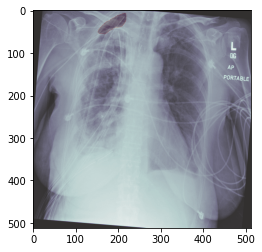

In [0]:
# plot some random images in the `batch`
idx = random.choice(range(16))
plt.imshow(images[idx][0], cmap='bone')
plt.imshow(masks[idx][0], alpha=0.2, cmap='Reds')
plt.show()
if len(np.unique(masks[idx][0])) == 1: # only zeros
    print('Chosen image has no ground truth mask, rerun the cell')

## **Losses**

Use a weighted sum of **Focal Loss** and **Dice Loss (F1 Score)**, call it MixedLoss.

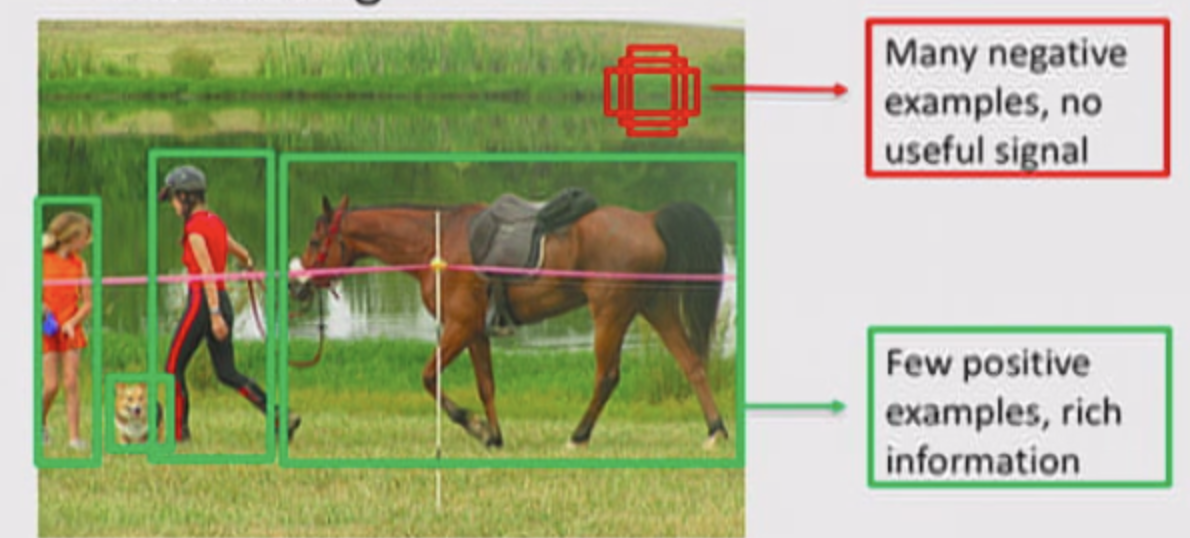

**Focal loss** adapts the standard CE to deal with extreme foreground-background class imbalance, where the loss assigned to well-classified examples is reduced. There are easy examples are well classified i.e. with a probability >> 0.5, as a result of which their contribution to the loss is very less. But they may be way greater than the number of positive examples, like in a ratio 10000:1 negatives to positives. Then its contribution to the loss is huge, thereby causing the network biased to background class.

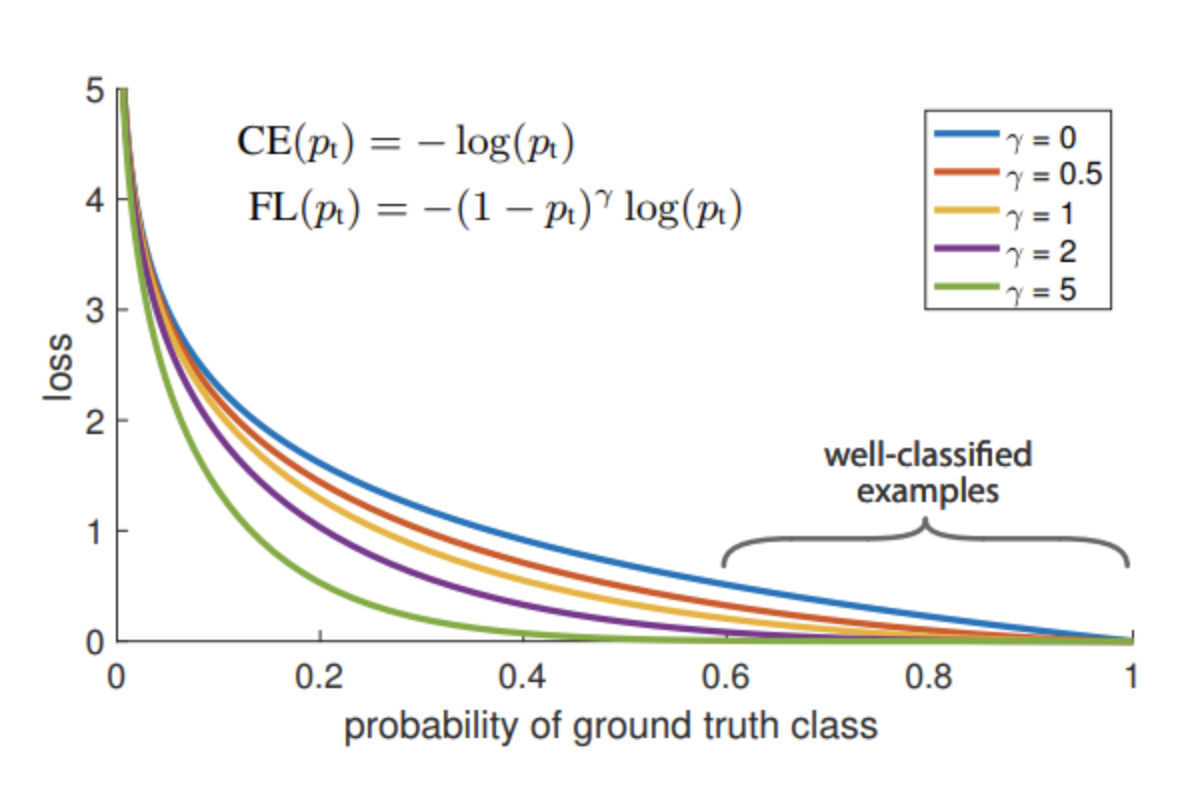

**Dice loss** is a statistic to gauge the similarity between two samples. Dice coefficient (DSC) is a measure of overlap between two sets. For example, if two sets A and B overlap perfectly, DSC gets its maximum value to 1. Otherwise, DSC starts to decrease, getting to its minimum value to 0 if the two sets don ‘t overlap at all. Therefore, the range of DSC is between 0 and 1, the larger the better. Thus we can use 1-DSC as Dice loss to maximize the overlap between two sets.

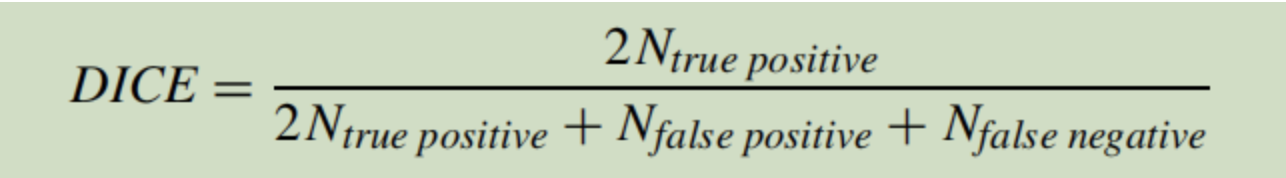

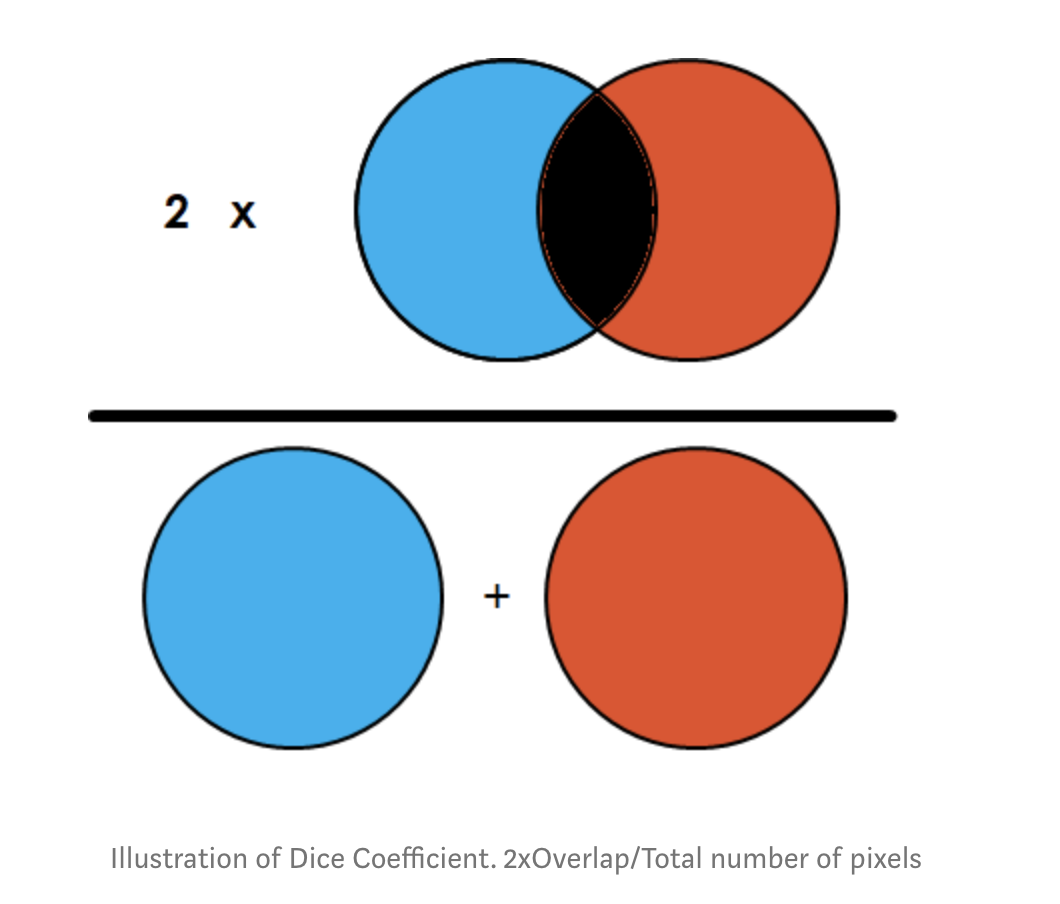

Combine Dice Loss and Focal Loss: https://arxiv.org/pdf/1808.05238.pdf

Small object segmentation is always a challenge in semantic segmentation. Image semantic segmentation requires pixel-wise
labeling and small-volumed masks contribute less to the
loss.
The dice loss improves the accuracy and part of alleviates the
imbalanced problem, where as the focal loss forces
the model to learn poorly classified masks better, making the optimization more stable in the extremely unbalanced segmentation.

In [0]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

Calculating IoU and Dice scores.

**Intersection-Over-Union, IoU**, is one of the most commonly used metrics in semantic segmentation. IoU is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between the predicted segmentation and the ground truth, as shown on the image to the left. This metric ranges from 0–1 (0–100%) with 0 signifying no overlap (garbage) and 1 signifying perfectly overlapping segmentation (fat dub).

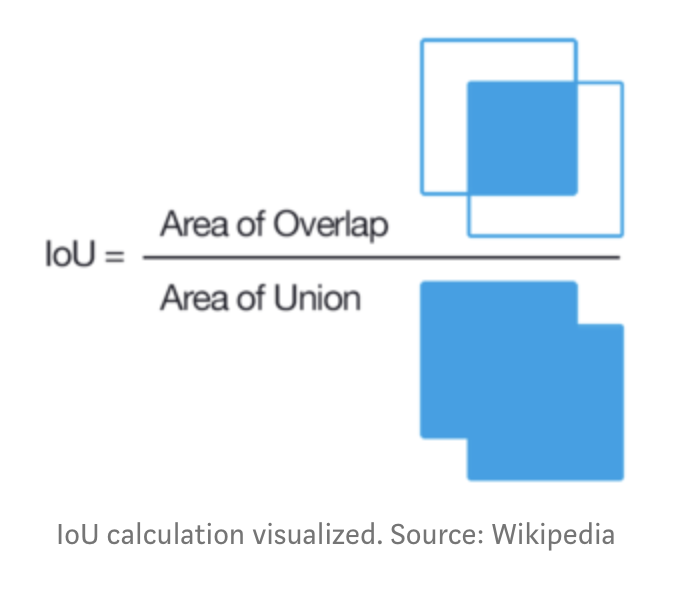

In general, the IoU metric tends to penalize single instances of bad classification more than the Dice score quantitatively even when they can both agree that this one instance is bad. Similarly to how L2 can penalize the largest mistakes more than L1, the IoU metric tends to have a "squaring" effect on the errors relative to the Dice score. So the Dice score tends to measure something closer to average performance, while the IoU score measures something closer to the worst case performance.

In [0]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):

    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []
    
    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        self.dice_pos_scores.extend(dice_pos)
        self.dice_neg_scores.extend(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

## **UNet model**

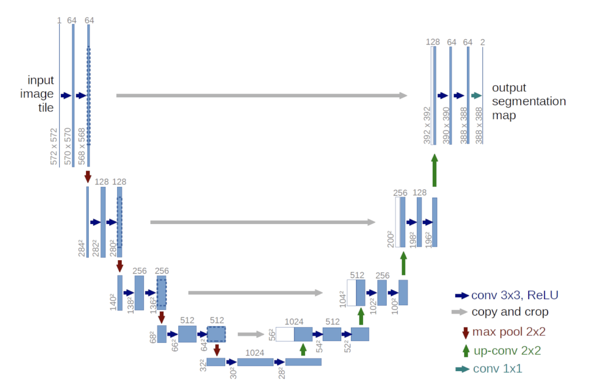

* Paper: https://arxiv.org/abs/1505.04597

* Brief Intro: https://towardsdatascience.com/unet-line-by-line-explanation-9b191c76baf5


Transposed convolution is an upsampling technic that expands the size of images.

After the transposed convolution, the image is upsized from 28x28x1024 → 56x56x512, and then, this image is concatenated with the corresponding image from the contracting path and together makes an image of size 56x56x1024. The reason here is to combine the information from the previous layers in order to get a more precise prediction.


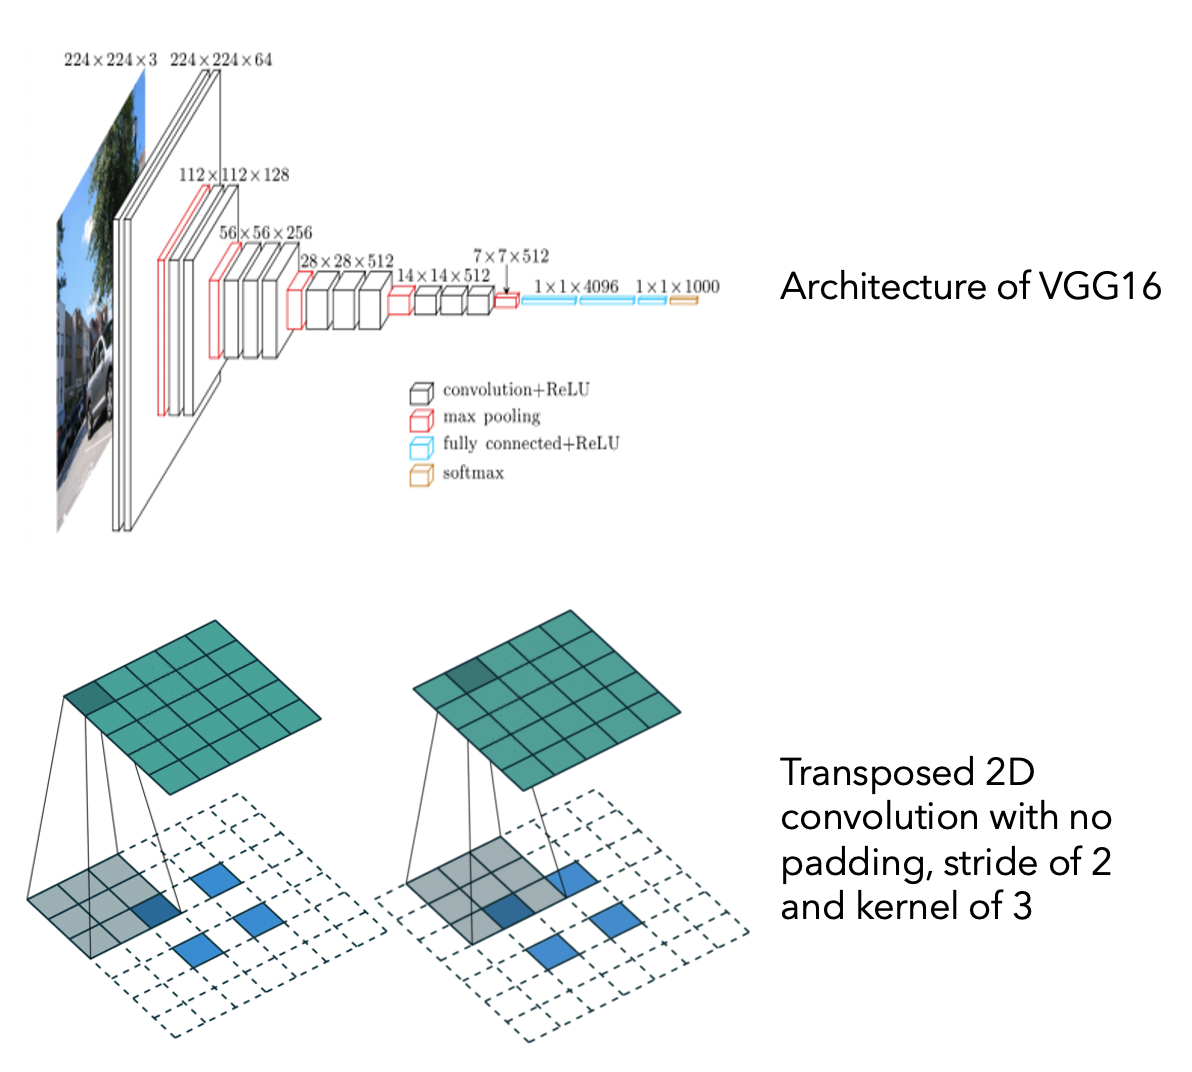

According to the structure of UNet, it can combine information in high layers. 
* Deep layers information: low-resolution information after 
multiple downsampling. It can provide contextual semantic information of the segmentation target in the entire image, which can be understood as a feature reflecting the relationship between the target and its environment. This feature is helpful for the classification of objects (so classification problems usually only require low-resolution / deep information and do not involve multi-scale fusion)

* High layers (shallow) information: after concatenate operation, the high-resolution information is directly transferred from the encoder to the decoder of the same height, so it can provide more refined features for segmentation, such as gradients, etc.

**Why apply to medical images?** 

* Because medical images have blurred boundaries and complex gradients, more high-resolution information is required. High resolution is used for precise segmentation. 
* The internal structure of the human body is relatively fixed, the distribution of segmentation targets in the human body image is very regular, the semantics are simple and clear, and low-resolution information can provide this information for the identification of target objects.
* The use of the high-layer features (same resolution concatenate) to improve the lack of information on upsampling.
* The volumes of medical image data is generally small, and the high-layer features are actually very important as well.

**UNet combines low-resolution information (providing basis for object category recognition) and high-resolution information (providing accurate segmentation and positioning basis), which is perfect for medical image segmentation.**

**Segmentation-Models-PyTorch**

https://github.com/qubvel/segmentation_models.pytorch

In [0]:
model = smp.Unet(encoder_weights="imagenet")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


## **Model training and validation - UNet**

In [0]:
class Trainer(object):
    '''This class takes care of training and validation of the model'''
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 40
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=train_folder,
                df_path=train_rle_path,
                phase=phase,
                size=512,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
    
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs
    
    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss
    
    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model_unet.pth")
            print()



In [0]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 17:08:01
Loss: 4.1727 | dice: 0.1502 | dice_neg: 0.0221 | dice_pos: 0.2782 | IoU: 0.1808
Starting epoch: 0 | phase: val | ⏰: 17:11:10
Loss: 3.2278 | dice: 0.1801 | dice_neg: 0.0441 | dice_pos: 0.3160 | IoU: 0.2090
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 17:11:45
Loss: 2.6674 | dice: 0.2375 | dice_neg: 0.1187 | dice_pos: 0.3564 | IoU: 0.2440
Starting epoch: 1 | phase: val | ⏰: 17:14:45
Loss: 2.6863 | dice: 0.1552 | dice_neg: 0.0147 | dice_pos: 0.2958 | IoU: 0.1912
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 17:15:19
Loss: 2.3515 | dice: 0.2657 | dice_neg: 0.1876 | dice_pos: 0.3439 | IoU: 0.2426
Starting epoch: 2 | phase: val | ⏰: 17:18:18
Loss: 1.9782 | dice: 0.4267 | dice_neg: 0.4979 | dice_pos: 0.3556 | IoU: 0.2577
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 17:18:51
Loss: 2.1662 | dice: 0.3080 | dice_neg: 0.23

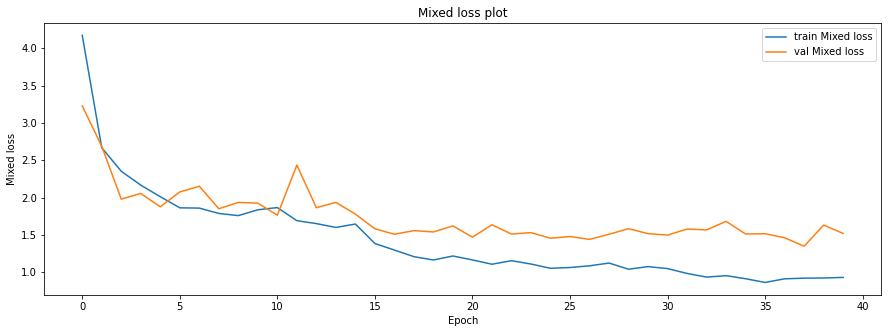

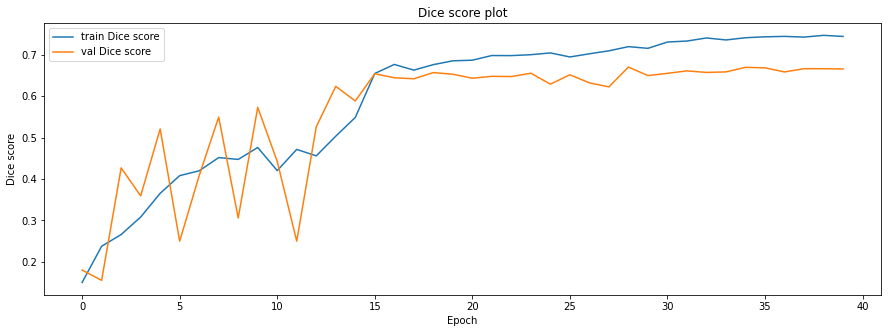

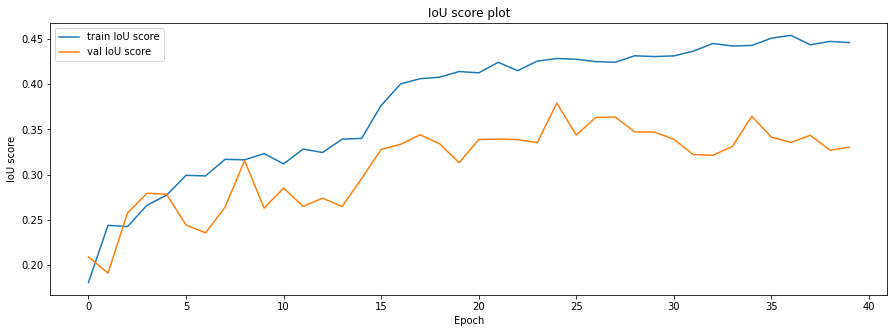

In [0]:
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "Mixed loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

## **UNet with ResNet34 model**

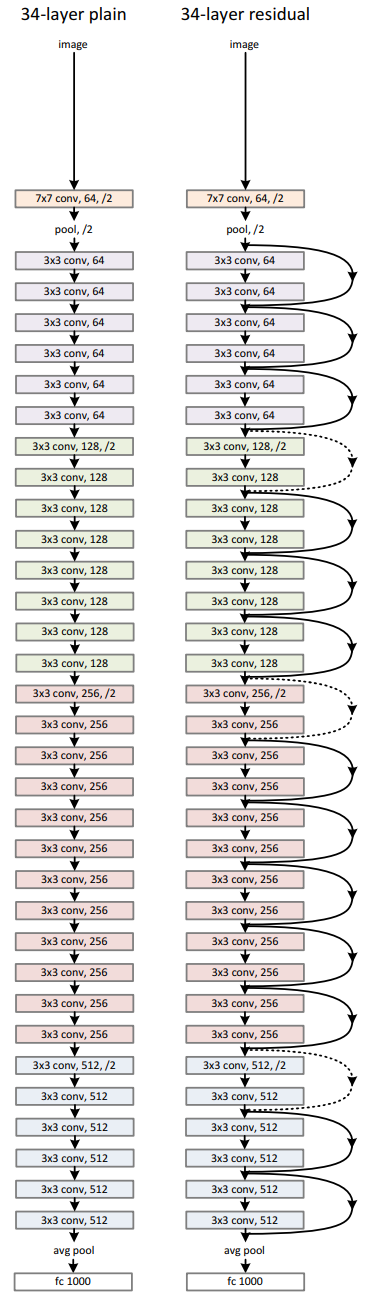

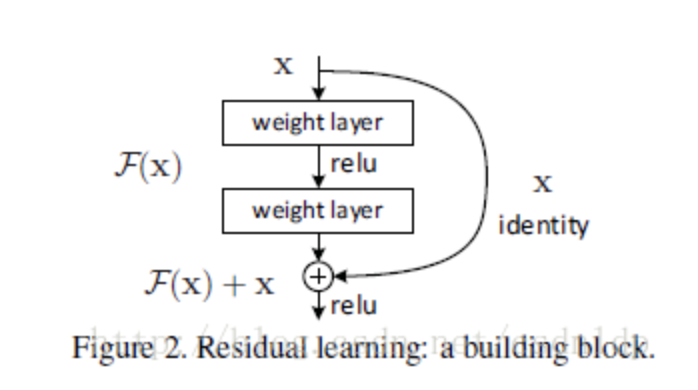

One of the problems ResNets solve is the famous known **vanishing gradient**. This is because when the network is too deep, the gradients from where the loss function is calculated easily shrink to zero after several applications of the chain rule. This result on the weights never updating its values and therefore, no learning is being performed.
With ResNets, the gradients can flow directly through the skip connections backwards from later layers to initial filters.

In [0]:
model_res34 = smp.Unet("resnet34", encoder_weights="imagenet")

## **Model training and validation - UNet with ResNet34**

In [0]:
class Trainer_res34(object):
    '''This class takes care of training and validation of the model'''
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 40
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                fold=1,
                total_folds=5,
                data_folder=train_folder,
                df_path=train_rle_path,
                phase=phase,
                size=512,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
    
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs
    
    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
            epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss
    
    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()



In [0]:
model_trainer_res34 = Trainer_res34(model_res34)
model_trainer_res34.start()

Starting epoch: 0 | phase: train | ⏰: 19:20:08
Loss: 4.5122 | dice: 0.1447 | dice_neg: 0.0247 | dice_pos: 0.2647 | IoU: 0.1673
Starting epoch: 0 | phase: val | ⏰: 19:22:50
Loss: 3.2802 | dice: 0.1554 | dice_neg: 0.0000 | dice_pos: 0.3109 | IoU: 0.2089
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 19:23:19
Loss: 2.8240 | dice: 0.2664 | dice_neg: 0.1745 | dice_pos: 0.3584 | IoU: 0.2475
Starting epoch: 1 | phase: val | ⏰: 19:26:02
Loss: 2.4858 | dice: 0.3626 | dice_neg: 0.4307 | dice_pos: 0.2946 | IoU: 0.1976
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 19:26:33
Loss: 2.2828 | dice: 0.2922 | dice_neg: 0.2181 | dice_pos: 0.3663 | IoU: 0.2617
Starting epoch: 2 | phase: val | ⏰: 19:29:14
Loss: 2.0388 | dice: 0.4094 | dice_neg: 0.4496 | dice_pos: 0.3693 | IoU: 0.2640
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 19:29:44
Loss: 2.1108 | dice: 0.3354 | dice_neg: 0.29

PLOT TRAINING

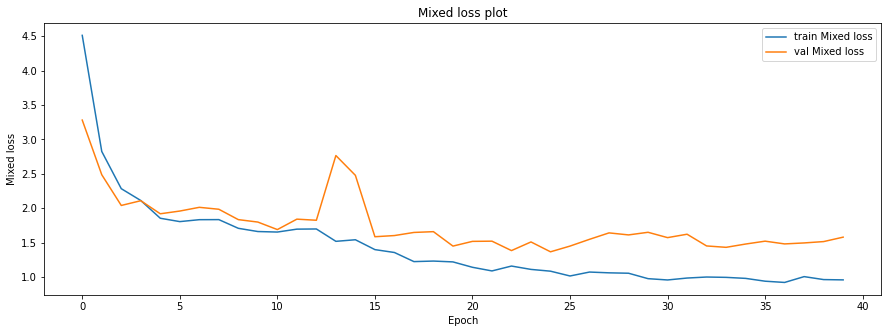

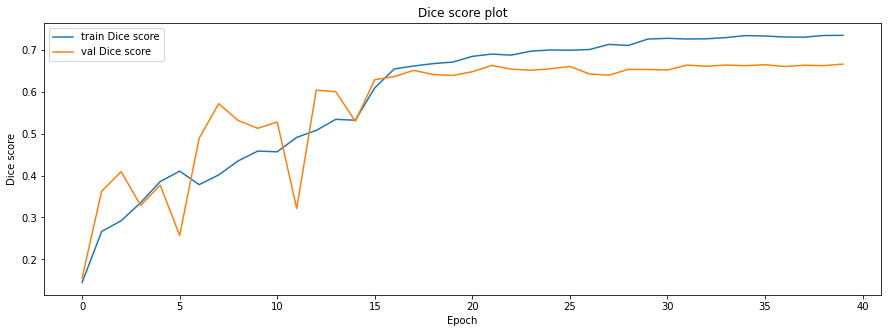

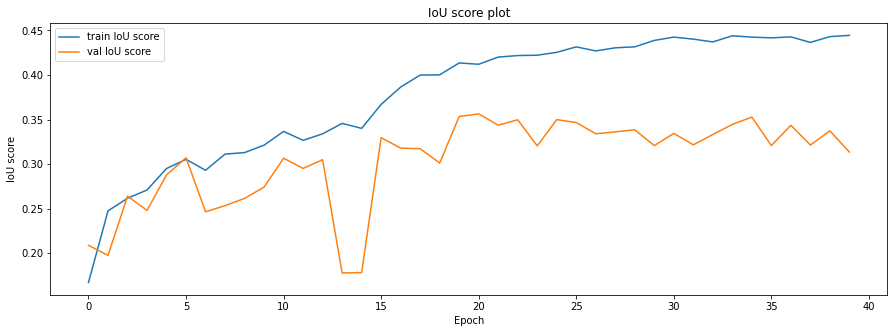

In [0]:
losses_res34 = model_trainer_res34.losses
dice_scores_res34 = model_trainer_res34.dice_scores # overall dice
iou_scores_res34 = model_trainer_res34.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses_res34, "Mixed loss")
plot(dice_scores_res34, "Dice score")
plot(iou_scores_res34, "IoU score")

# **Test prediction**

In [0]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".png")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return images
    
    def __len__(self):
        return self.num_samples

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [0]:
sample_submission_path = '/content/sample_submission.csv'
size = 512
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
num_workers = 8
batch_size = 16
best_threshold = 0.5
min_size = 3500
device = torch.device("cuda:0")
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_folder, df, size, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
)
model = model_trainer.net # get the model from model_trainer object
model.eval()
state = torch.load('./model.pth', map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])
encoded_pixels = []
for i, batch in enumerate(tqdm(testset)):
    preds = torch.sigmoid(model(batch.to(device)))
    preds = preds.detach().cpu().numpy()[:, 0, :, :] # (batch_size, 1, size, size) -> (batch_size, size, size)
    for probability in preds:
        if probability.shape != (1024, 1024):
            probability = cv2.resize(probability, dsize=(1024, 1024), interpolation=cv2.INTER_LINEAR)
        predict, num_predict = post_process(probability, best_threshold, min_size)
        if num_predict == 0:
            encoded_pixels.append('-1')
        else:
            r = run_length_encode(predict)
            encoded_pixels.append(r)
df['EncodedPixels'] = encoded_pixels
df.to_csv('submission.csv', columns=['ImageId', 'EncodedPixels'], index=False)

In [0]:
df.head()

ImageId                                      EncodedPixels
0  1.2.276.0.7230010.3.1.4.8323329.6067.151787519...                                                 -1
1  1.2.276.0.7230010.3.1.4.8323329.6214.151787519...                                                 -1
2  1.2.276.0.7230010.3.1.4.8323329.6177.151787519...  545887 13 1008 16 1005 20 1003 21 1001 23 1000...
3  1.2.276.0.7230010.3.1.4.8323329.6655.151787519...                                                 -1
4  1.2.276.0.7230010.3.1.4.8323329.6359.151787519...                                                 -1

In [0]:
test_id = df.iloc[2,0]

In [0]:
test_mask = []
test_mask.append(df.iloc[2,1])

image id: 1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733


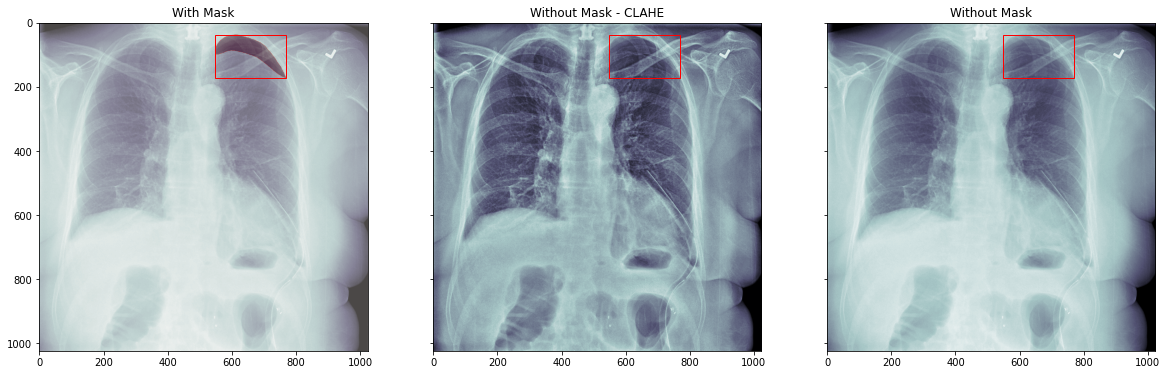

In [0]:
data_sample = data_df[data_df['id']==test_id]
# plot X-ray with and without mask
for index, row in data_sample.iterrows():
    file_path = row['file_path']
    mask_encoded_list = row['encoded_pixels_list']
    print('image id: ' + row['id'])
    plot_with_mask_and_bbox(file_path, mask_encoded_list)

image id: 1.2.276.0.7230010.3.1.4.8323329.6177.1517875196.880733


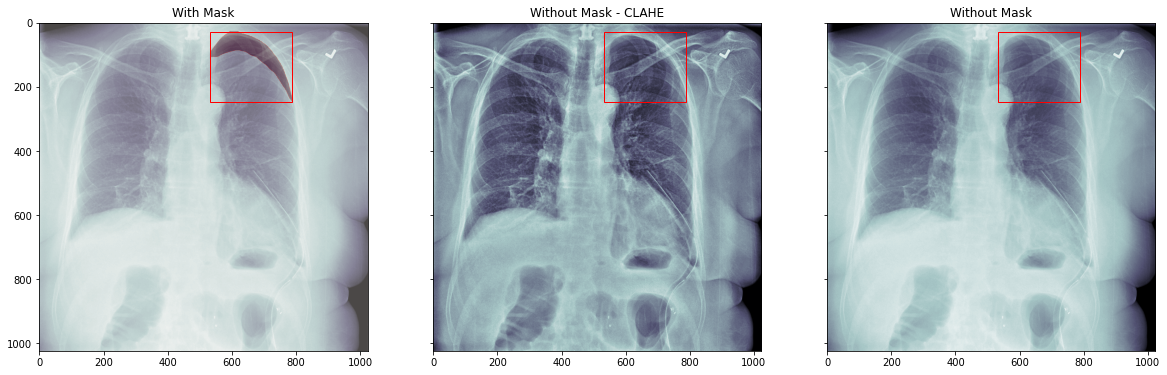

In [0]:
for index, row in data_sample.iterrows():
    file_path = row['file_path']
    mask_encoded_list = test_mask
    print('image id: ' + row['id'])
    plot_with_mask_and_bbox(file_path, mask_encoded_list)

# **Conclusion**

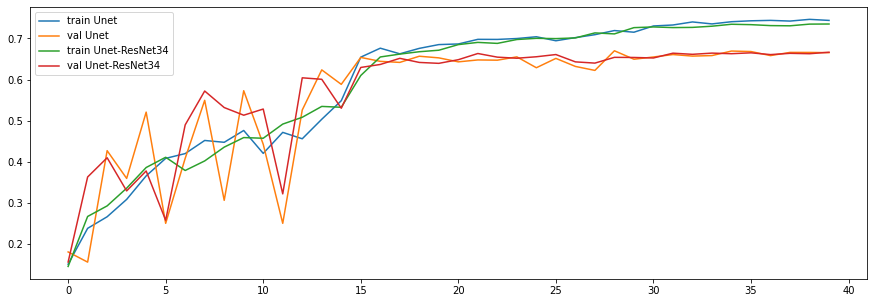

In [0]:
plt.figure(figsize=(15,5))
plt.plot(range(len(dice_scores["train"])), dice_scores["train"], label=f'train Unet')
plt.plot(range(len(dice_scores["train"])), dice_scores["val"], label=f'val Unet')
plt.plot(range(len(dice_scores_res34["train"])), dice_scores_res34["train"], label=f'train Unet-ResNet34')
plt.plot(range(len(dice_scores_res34["train"])), dice_scores_res34["val"], label=f'val Unet-ResNet34')
plt.legend()

UNet with ResNet34 performs nearly the same as the original UNet model.

Got the final model Unet / Unet with ResNet34 encoder for validation set with dice score around 0.65 and IoU around 0.36.